In [1]:
import numpy as np
import time
from math import sqrt, pi, exp
import functools
import scipy
import matplotlib.pylab as pl
from varname import nameof


from utils.preconditioners import *
from utils.algorithms import *
from utils.functions import *

### Test case "banana"


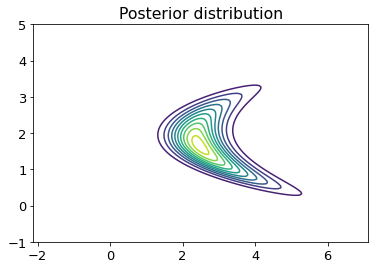

In [2]:
d = 2 

y = 0 
xmin = -2
xmax = 7
ymin= -1
ymax= 5


# potential function
sigNoise = 0.5
sigPrior = 2

G = lambda u: ((u[1]-2)**2-(u[0]-3.5) -1)
Phi = lambda u: 0.5/(sigNoise**2)*(G(u)-y)**2 #likelihood


# potential function
I = lambda u: Phi(u) + 0.5/(sigPrior**2)*np.linalg.norm(u,axis=0)**2


# Plot test case
u0s = np.linspace(xmin,xmax,150)
u1s = np.linspace(ymin,ymax,150)
U0, U1 = np.meshgrid(u0s,u1s)
U = np.stack((U0,U1))

plt.figure()
plt.contour(U0, U1, np.exp(-I(U)), 10)
plt.axis('equal')
plt.title("Posterior distribution")



unnorm_dens = np.exp(-I(U))
Z = np.trapz(unnorm_dens, u0s, axis=1)
Z = np.trapz(Z, u1s)
dens = unnorm_dens/Z

marg_over_x = np.trapz(dens, u0s, axis=1)
marg_over_y = np.trapz(dens, u1s, axis=0)

### Try algorithms 

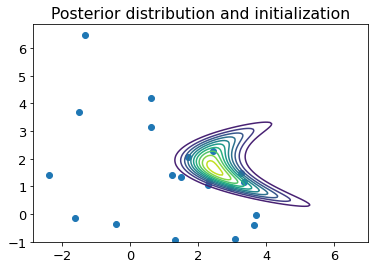

ULA: 36.52234435081482 seconds
ALDI with gradient: 35.485397815704346 seconds
iter
0
lambda min
1.980489906913124
trace D opt
2.0000000000000004



/Users/annakorba/Desktop/nreks/utils/algorithms.py:111: ComplexWarning: Casting complex values to real discards the imaginary part
  us_list_ALDINR[:,:,n+1] = us+tau*drift  + np.sqrt(tau)*diff


iter
100
lambda min
0.44222650260744323
trace D opt
2.0

iter
200
lambda min
0.14672140922543553
trace D opt
2.0

iter
300
lambda min
0.9841774836855351
trace D opt
1.9999999999999998

iter
400
lambda min
1.6982659997171392
trace D opt
2.000000000000001

iter
500
lambda min
2.0472894496491345
trace D opt
2.0

iter
600
lambda min
1.7363931319171328
trace D opt
2.0

iter
700
lambda min
1.3986621912206405
trace D opt
2.0000000000000004

iter
800
lambda min
1.3319782896894492
trace D opt
2.0000000000000004

iter
900
lambda min
1.3930817190333666
trace D opt
2.0

iter
1000
lambda min
1.6082639901069207
trace D opt
2.0000000000000004

iter
1100
lambda min
1.8406493739496959
trace D opt
2.0000000000000004

iter
1200
lambda min
1.2003282790131218
trace D opt
2.0000000000000004

iter
1300
lambda min
0.9268205409029318
trace D opt
2.0000000000000004

iter
1400
lambda min
0.926343541540673
trace D opt
2.0

iter
1500
lambda min
0.7356137043041031
trace D opt
2.0000000000000004

iter
1600
lambda mi

In [67]:
# parameters of all the algorithms

J = 20  # number of particles 
N_sim = 4000 # number of iterations
d = 2 # dimension
tau = 1e-4 # step size

# parameters of our algorithm
const = 1.5 

# initial position of the particles
u0 = np.random.normal(2,2,(d,J)) 

plt.figure()
plt.contour(U0, U1, np.exp(-I(U)), 10)
plt.scatter(u0[0],u0[1])
plt.title("Posterior distribution and initialization")
plt.show()




# run algorithms


# ULA
start_time = time.time()
us_list_ULA = run_ULA(I, N_sim, u0, tau)
np.save('save_data/banana/ULA_J_'+str(us_list_ULA.shape[1])+'_Nsim_'\
        +str(us_list_ULA.shape[2])+'_tau_'+str(tau)+'.npy', us_list_ULA)
print(f"ULA: {time.time()-start_time} seconds")

# ALDI 
start_time = time.time()
us_list_ALDI = run_ALDI_with_gradient(I, N_sim, u0, tau)
np.save('save_data/banana/ALDI_J_'+str(us_list_ALDI.shape[1])+'_Nsim_'\
                    +str(us_list_ALDI.shape[2])+'_tau_'+str(tau)+'.npy', us_list_ALDI)
print(f"ALDI with gradient: {time.time()-start_time} seconds")


# NRALDI (our scheme)
# eventually new parameters like stepsize

tau_ALDINR = 1e-4
#tau_ALDINR = tau

start_time = time.time()
us_list_ALDINR, preconditioners = run_ALDINR(I, N_sim, u0, tau_ALDINR, const) 


# save data
np.save('save_data/banana/ALDINR_J_'\
                      +str(us_list_ALDINR.shape[1])+'_Nsim_'+str(us_list_ALDINR.shape[2])+'_tau_'+str(tau_ALDINR)+'.npy', us_list_ALDINR)

np.save('save_data/banana/ALDINR_J_'\
                      +str(us_list_ALDINR.shape[1])+'_Nsim_'+str(us_list_ALDINR.shape[2])+'_tau_'+str(tau_ALDINR)\
                      +'_preconditioners'+'.npy', preconditioners)

print(f"ALDI NR: {time.time()-start_time} seconds")



In [69]:
# load data

us_list_ULA = np.load('save_data/banana/ULA_J_20_Nsim_4000_tau_0.0001.npy')
us_list_ALDI = np.load('save_data/banana/ALDI_J_20_Nsim_4000_tau_0.0001.npy')
us_list_ALDINR = np.load('save_data/banana/ALDINR_J_20_Nsim_4000_tau_0.0001.npy')

#preconditioners_ALDINR = np.load('save_data/banana/ALDINR_J_20_Nsim_3000_tau_0.0001_preconditioners.npy')

#tau = 0.001
#tau_ALDINR = 0.0001

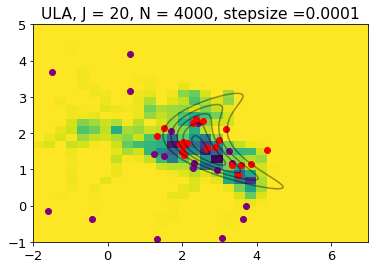

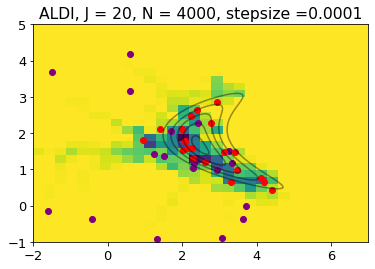

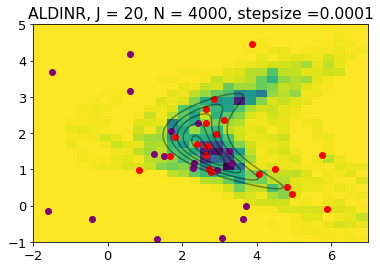

In [76]:
# plot results
    
name = nameof(us_list_ULA).lstrip('us_list')
plot_results(I, us_list_ULA, tau, name, xmin = -2, xmax = 7, ymin = -1, ymax = 5)
plt.scatter(us_list_ULA[0, :, 0], us_list_ULA[1, :, 0], color = "purple")
plt.scatter(us_list_ULA[0, :, -1], us_list_ULA[1, :, -1], color = "red")

name = nameof(us_list_ALDI).lstrip('us_list')
plot_results(I, us_list_ALDI, tau, name, xmin = -2, xmax = 7, ymin = -1, ymax = 5)
plt.scatter(us_list_ALDI[0, :, 0], us_list_ALDI[1, :, 0], color = "purple")
plt.scatter(us_list_ALDI[0, :, -1], us_list_ALDI[1, :, -1], color = "red")

    
name = nameof(us_list_ALDINR).lstrip('us_list')
plot_results(I, us_list_ALDINR, tau_ALDINR, name, xmin = -2, xmax = 7, ymin = -1, ymax = 5)
plt.scatter(us_list_ALDINR[0, :, 0], us_list_ALDINR[1, :, 0], color = "purple")
plt.scatter(us_list_ALDINR[0, :, -1], us_list_ALDINR[1, :, -1], color = "red")


## plot statistics for ALDINR

In [71]:
# compute means and covariances

J = us_list_ULA.shape[1]
N_sim = us_list_ULA.shape[2]


means_ULA = np.mean(us_list_ULA, axis = 1)
means_ALDI = np.mean(us_list_ALDI, axis = 1)
means_ALDINR = np.mean(us_list_ALDINR, axis = 1)


covariances_ULA = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ULA[:,:, i] = np.cov(us_list_ULA[:, :, i])*(J-1)/J
 
covariances_ALDI = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ALDI[:,:, i] = np.cov(us_list_ALDI[:, :, i])*(J-1)/J

covariances_ALDINR = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ALDINR[:,:, i] = np.cov(us_list_ALDINR[:, :, i])*(J-1)/J

Text(0.5, 1.0, 'Distance to mean (|| mean(particles) - mean(target)||)')

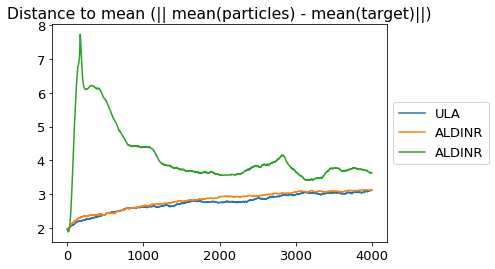

In [72]:
distances_to_mean_ULA = np.linalg.norm(means_ULA, axis=0)
plt.plot(distances_to_mean_ULA, label = 'ULA' )

distances_to_mean_ALDI = np.linalg.norm(means_ALDI, axis=0)
plt.plot(distances_to_mean_ALDI, label = 'ALDINR' )

distances_to_mean_ALDINR = np.linalg.norm(means_ALDINR, axis=0)
plt.plot(distances_to_mean_ALDINR, label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Distance to mean (|| mean(particles) - mean(target)||)')

Text(0.5, 1.0, 'Norm of C-K along iter')

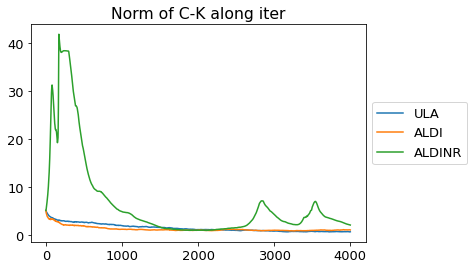

In [73]:
distances_to_covariances_ULA = np.asarray([np.linalg.norm(covariances_ULA[:, :, i]) for i in range(covariances_ULA.shape[2])])
plt.plot(distances_to_covariances_ULA, label ='ULA')

distances_to_covariances_ALDI = np.asarray([np.linalg.norm(covariances_ALDI[:, :, i]) for i in range(covariances_ALDI.shape[2])])
plt.plot(distances_to_covariances_ALDI, label ='ALDI')

distances_to_covariances_ALDINR = np.asarray([np.linalg.norm(covariances_ALDINR[:, :, i]) for i in range(covariances_ALDINR.shape[2])])
plt.plot(distances_to_covariances_ALDINR, label ='ALDINR')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Norm of C-K along iter')

Text(0.5, 1.0, 'Trace of C along ALDINR')

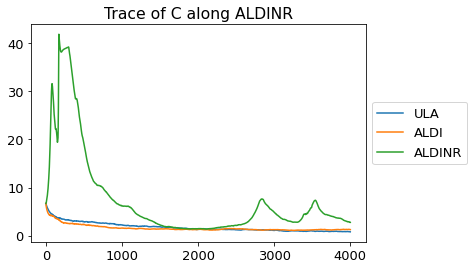

In [74]:
traces_of_C_ULA = np.asarray([np.trace(covariances_ULA[:, :, i]) for  i in range(covariances_ULA.shape[2])] )
traces_of_C_ALDI = np.asarray([np.trace(covariances_ALDI[:, :, i]) for  i in range(covariances_ALDI.shape[2])] )
traces_of_C_ALDINR = np.asarray([np.trace(covariances_ALDINR[:, :, i]) for  i in range(covariances_ALDINR.shape[2])] )

plt.plot(traces_of_C_ULA, label ='ULA')
plt.plot(traces_of_C_ALDI, label ='ALDI')
plt.plot(traces_of_C_ALDINR, label ='ALDINR')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Trace of C along ALDINR')


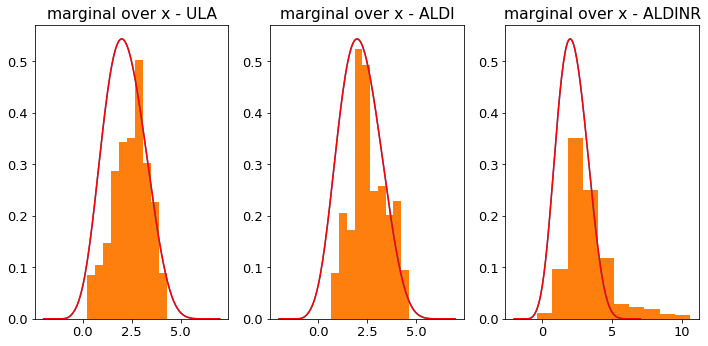

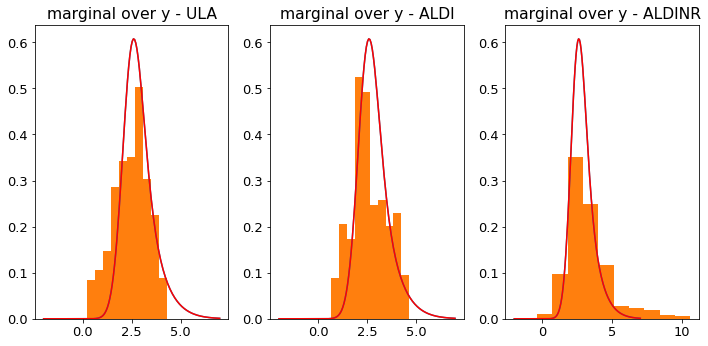

In [75]:
binsx = np.linspace(xmin,xmax,31)
binsy = np.linspace(ymin,ymax,31)

# marginal over x

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(5)
fig.set_figwidth(10)

plt.subplot(1,3,1)
plt.plot(u0s, marg_over_x)
plt.hist(us_list_ULA[0,:,2000:].flatten(), density=True)
plt.plot(u0s, marg_over_x, color = 'red')
plt.title('marginal over x - ULA')

plt.subplot(1,3,2)
plt.plot(u0s, marg_over_x)
plt.hist(us_list_ALDI[0,:,2000:].flatten(), density=True)
plt.plot(u0s, marg_over_x, color = 'red')
plt.title('marginal over x - ALDI')

plt.subplot(1,3,3)
plt.plot(u0s, marg_over_x)
plt.hist(us_list_ALDINR[0,:,2000:].flatten(), density=True)
plt.plot(u0s, marg_over_x, color = 'red')
plt.title('marginal over x - ALDINR')
fig.tight_layout()

# marginal over y

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(5)
fig.set_figwidth(10)

plt.subplot(1,3,1)
plt.plot(u0s, marg_over_y)
plt.hist(us_list_ULA[0,:,2000:].flatten(), density=True)
plt.plot(u0s, marg_over_y, color = 'red')
plt.title('marginal over y - ULA')

plt.subplot(1,3,2)
plt.plot(u0s, marg_over_y)
plt.hist(us_list_ALDI[0,:,2000:].flatten(), density=True)
plt.plot(u0s, marg_over_y, color = 'red')
plt.title('marginal over y - ALDI')

plt.subplot(1,3,3)
plt.plot(u0s, marg_over_y)
plt.hist(us_list_ALDINR[0,:,2000:].flatten(), density=True)
plt.plot(u0s, marg_over_y, color = 'red')
plt.title('marginal over y - ALDINR')
plt.tight_layout()